In [9]:
# Run this cell to update data after doing a git pull

%matplotlib inline

import csv

taiwan_population = 23780000
singapore_population = 5639000
hongkong_population = 7451000
china_population = 1427647786  # mainland
usa_population = 329515103
italy_population = 60360000
southkorea_population = 51640000
japan_population = 126500000


# Convert a list of strings into a list of ints
def to_int(row: list) -> list:
    return [int(r) for r in row]


# Add values corresponding to the same position in multiple lists 
# (for countries that have multiple regions in the data)
def add_row(old_row: list, new_row: list) -> list:
    if old_row == []:
        return to_int(new_row)
    else:
        return[o + int(n) for o, n in zip(old_row, new_row)]
            

# Get confirmed cases
china_confirmed = []
with open('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[1] == "Country/Region":
            dates = row[4:]
        elif row[1] == "Taiwan*":
            taiwan_confirmed = to_int(row[4:])
        elif row[1] == "Singapore":
            singapore_confirmed = to_int(row[4:])
        elif row[0] == "Hong Kong":
            hongkong_confirmed = to_int(row[4:])
        elif row[1] == "China" and row[0] != "Hong Kong":  # mainland
            china_confirmed = add_row(china_confirmed, row[4:])
        elif row[1] == "US":  
            usa_confirmed = to_int(row[4:])
        elif row[1] == "Italy":  
            italy_confirmed = to_int(row[4:])
        elif row[1] == "Korea, South":  
            southkorea_confirmed = to_int(row[4:])
        elif row[1] == "Japan":  
            japan_confirmed = to_int(row[4:])
        
            
            
# Get deaths
china_deaths = []
with open('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[1] == "Taiwan*":
            taiwan_deaths = to_int(row[4:])
        elif row[1] == "Singapore":
            singapore_deaths = to_int(row[4:])
        elif row[0] == "Hong Kong":
            hongkong_deaths = to_int(row[4:])
        elif row[1] == "China" and row[0] != "Hong Kong":  # mainland
            china_deaths = add_row(china_deaths, row[4:])
        elif row[1] == "US": 
            usa_deaths = to_int(row[4:])
        elif row[1] == "Italy": 
            italy_deaths = to_int(row[4:])
        elif row[1] == "Korea, South":  
            southkorea_deaths = to_int(row[4:])
        elif row[1] == "Japan":  
            japan_deaths = to_int(row[4:])
            
            
            
as_of_date = dates[-1] # The last date that was recorded
            
            

In [10]:
# Run this cell to get current stats for the countries we care about

# Confirmed over population
taiwan_cop = taiwan_confirmed[-1]/taiwan_population
singapore_cop = singapore_confirmed[-1]/singapore_population
hongkong_cop = hongkong_confirmed[-1]/hongkong_population
china_cop = china_confirmed[-1]/china_population
usa_cop = usa_confirmed[-1]/usa_population
italy_cop = italy_confirmed[-1]/italy_population
southkorea_cop = southkorea_confirmed[-1]/southkorea_population
japan_cop = japan_confirmed[-1]/japan_population

# Deaths over confirmed
taiwan_doc = taiwan_deaths[-1]/taiwan_confirmed[-1]
singapore_doc = singapore_deaths[-1]/singapore_confirmed[-1]
hongkong_doc = hongkong_deaths[-1]/hongkong_confirmed[-1]
china_doc = china_deaths[-1]/china_confirmed[-1]
usa_doc = usa_deaths[-1]/usa_confirmed[-1]
italy_doc = italy_deaths[-1]/italy_confirmed[-1]
southkorea_doc = southkorea_deaths[-1]/southkorea_confirmed[-1]
japan_doc = japan_deaths[-1]/japan_confirmed[-1]

# Deaths over population
taiwan_dop = taiwan_deaths[-1]/taiwan_population
singapore_dop = singapore_deaths[-1]/singapore_population
hongkong_dop = hongkong_deaths[-1]/hongkong_population
china_dop = china_deaths[-1]/china_population
usa_dop = usa_deaths[-1]/usa_population
italy_dop = italy_deaths[-1]/italy_population
southkorea_dop = southkorea_deaths[-1]/southkorea_population
japan_dop = japan_deaths[-1]/japan_population

print('As of', as_of_date)
print('Region, Confirmed, Deaths')
print('Taiwan', taiwan_confirmed[-1], taiwan_deaths[-1])
print('Singapore', singapore_confirmed[-1], singapore_deaths[-1])
print('Hong Kong', hongkong_confirmed[-1], hongkong_deaths[-1])
print('South Korea', southkorea_confirmed[-1], southkorea_deaths[-1])
print('Japan', japan_confirmed[-1], japan_deaths[-1])
print('China', china_confirmed[-1], china_deaths[-1])
print('USA', usa_confirmed[-1], usa_deaths[-1])
print('Italy', italy_confirmed[-1], italy_deaths[-1])
print('Total HK, Taiwan, Singapore', hongkong_confirmed[-1]+singapore_confirmed[-1]+taiwan_confirmed[-1], hongkong_deaths[-1]+singapore_deaths[-1]+taiwan_deaths[-1])

As of 4/13/20
Region, Confirmed, Deaths
Taiwan 393 6
Singapore 2918 9
Hong Kong 1009 4
South Korea 10537 217
Japan 7370 123
China 82204 3341
USA 580619 23529
Italy 159516 20465
Total HK, Taiwan, Singapore 4320 19


Text(0.5, 1.0, 'Confirmed Cases')

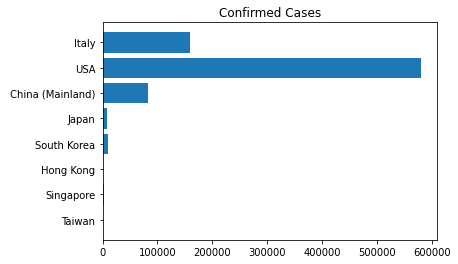

In [11]:
# Run the following cells to get charts comparing rates of infection, death, and population

import matplotlib.pyplot as plt

regions = ['Taiwan', 'Singapore', 'Hong Kong', 'South Korea', 'Japan', ' China (Mainland)', 'USA', 'Italy']

# Total Cases
confirmed = [taiwan_confirmed[-1], singapore_confirmed[-1], hongkong_confirmed[-1], southkorea_confirmed[-1], japan_confirmed[-1], china_confirmed[-1], usa_confirmed[-1], italy_confirmed[-1]]
plt.barh(regions, confirmed)
plt.title("Confirmed Cases")

Text(0.5, 1.0, 'Total Deaths')

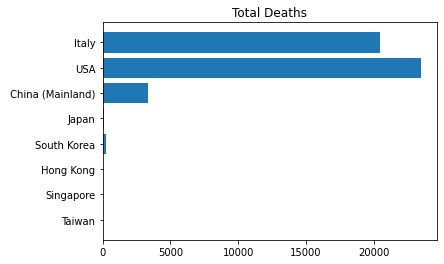

In [12]:
# Total Deaths
deaths = [taiwan_deaths[-1], singapore_deaths[-1], hongkong_deaths[-1], southkorea_deaths[-1], japan_deaths[-1], china_deaths[-1], usa_deaths[-1], italy_deaths[-1]]
plt.barh(regions, deaths)
plt.title("Total Deaths")

Text(0.5, 1.0, 'Confirmed Cases as % of Population')

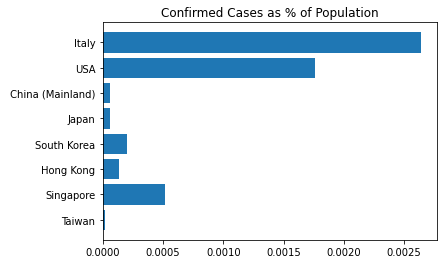

In [13]:
# Confirmed over population
cop = [taiwan_cop, singapore_cop, hongkong_cop, southkorea_cop, japan_cop, china_cop, usa_cop, italy_cop]
plt.barh(regions, cop)
plt.title("Confirmed Cases as % of Population")

Text(0.5, 1.0, 'Deaths as % of Confirmed Cases')

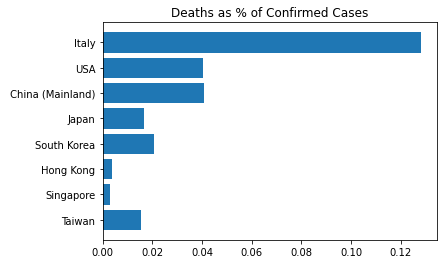

In [14]:
# Deaths over confirmed
doc = [taiwan_doc, singapore_doc, hongkong_doc, southkorea_doc, japan_doc, china_doc, usa_doc, italy_doc]
plt.barh(regions, doc)
plt.title("Deaths as % of Confirmed Cases")

Text(0.5, 1.0, 'Deaths as % of Population')

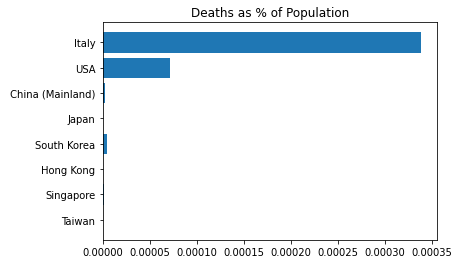

In [15]:
# Deaths over population
dop = [taiwan_dop, singapore_dop, hongkong_dop, southkorea_dop, japan_dop, china_dop, usa_dop, italy_dop]
plt.barh(regions, dop)
plt.title("Deaths as % of Population")

Text(0.5, 1.0, 'USA Confirmed Cases')

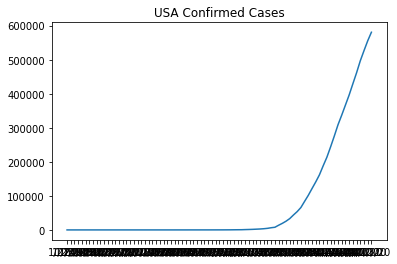

In [16]:
# Trajectory
plt.plot(dates, usa_confirmed)
plt.title("USA Confirmed Cases")